## About the dataset

The dataset contains **40,000 molecules** and labelled ``0`` or ``1`` based on their ability to inhibit **HIV**

We split our project into 5 modules:

1) Buiding the **dataset** - converting raw data into useful node and edge features
2) Building the **GNN**
3) **Generative GNN** - to generate arbitrary molecules that are potential HIV inhibitors
4) **Explainable AI** on graphs

### Step 1: Buiding the dataset - converting raw data into useful node and edge features

In [1]:
# imports
import pandas as pd

path = "data/raw/HIV.csv"
dataset = pd.read_csv(path)
dataset.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


So, the first column is the actual set of molecules. We want to convert these to graph so that we can pass as data to GNNs

In [2]:
# General info about dataset
print(dataset.shape)
print(dataset["HIV_active"].value_counts())

(41127, 3)
HIV_active
0    39684
1     1443
Name: count, dtype: int64


There are **41127 molecules** and out of that only **1443 molecules** are actually HIV inhibitors. We keep this in mind when selecting training and testing data. We might have to balance the dataset by under-sampling the negative samples.

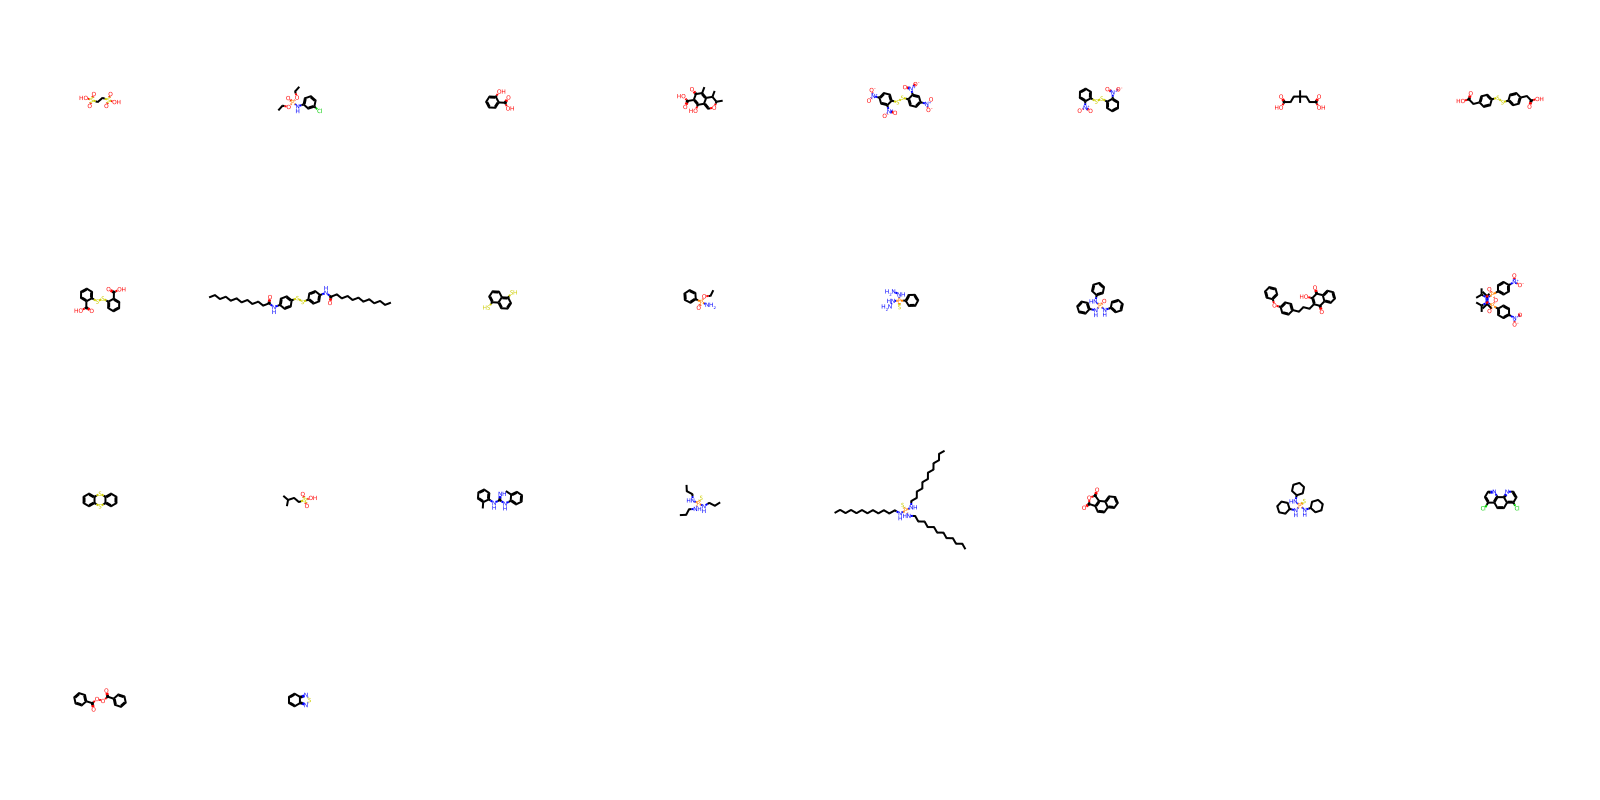

In [3]:
# Convert the smiles column to molecule structure
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# See for a small subset of molecules
sample_smiles = dataset["smiles"][4:30].values
sample_mols = [Chem.MolFromSmiles(smiles) for smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,molsPerRow=8,subImgSize=(200,200))

grid

Now that we have seen a few of the molecules as graph, let us move to creating the custom dataset using PyTorch Geometric. We use the method mentioned in Documentation that corresponds to creating a dataset that stores in your local machine instead of RAM

In [4]:
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

# We extend the functionalites in Dataset class
class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        """In this function we construct the graphs for each object in dataset
        """
        # Reading the dataset
        self.data = pd.read_csv(self.raw_paths[0])

        # Iterating over each object to get the required parameters to preprocess
        # tqdm gives process bar which tells us how far our process is done
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    # Based on domain knowledge we decide to get the node features
    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        # Iterating over each ATOM of the passed molecule object
        for atom in mol.GetAtoms():
            node_feats = []

            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    # Based on domain knowledge we decide to get the edge features
    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # Iterating over each BOND of the passed molecule object
        for bond in mol.GetBonds():
            edge_feats = []

            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())

            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data

In [5]:
# Process the dataset
dataset = MoleculeDataset(root="data/",filename='HIV.csv')

print(dataset[0].edge_index.t())
print(dataset[0].x)
print(dataset[0].y)
print(dataset[0].edge_attr)

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 6,  9],
        [ 9,  6],
        [ 4, 10],
        [10,  4],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [11, 14],
        [14, 11],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [15, 18],
        [18, 15],
        [ 9,  2],
        [ 2,  9],
        [18,  4],
        [ 4, 18]])
tensor([[ 6.,  1.,  0.,  4.,  0.,  3.,  0.,  0.,  0.],
        [ 6.,  2.,  0.,  4.,  0.,  2.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  0.,  0.,  0.,  1.,  0.],
        [ 8.,  2.,  1.,  3.,  0.,  0.,  0.,  1.,  0.],
        [29.,  4., -3.,  0.,  0.,  0.,  0.,  1.,  0.],
    

Now that the pre-processing is done, we can move on to building the GNN model to do graph-level predictions.

### Step 2: Building the GNN model

#### Task 1: Graph classification

Given a molecule, we classify it whether it is a HIV inhibitor (``1``) or not (``0``). For this task we need a feture vector for the whole graph instead of node-features or edge-features. There are a lot of approaches for this. We discuss a couple of them below:

1) **Naive pooling** - Apply mean/max/sum pooling to all node features to get the graph representation
2) **Hierarchical pooling** - similar to pooling done in images; at each step we share feature with neighbors. So, at each step we can drop the nodes in a specific manner so that finally we are left with a single node whose feature gives us the feature representation of the graph. The choice of nodes to drop is either done by either **Differential pooling** , which clusters nodes and pools its feature vectors and new graph with clusters as nodes is formed, or **Top-K pooling**, which squeezes the feature vectors to a single vector and top-K nodes are considered.
3) **Super/virtual/dummy node** - All nodes will pass their vectors to the super node during message passing but this node won't share its vector to others. The vector obtained by this node is the graph representation

In [ ]:
# Dataset changes
# Instead of manually assigning features here we us FEATURIZER by DeepChem

# import deepchem as dc

# class MoleculeDataset(Dataset):
#     def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
#         """
#         root = Where the dataset should be stored. This folder is split
#         into raw_dir (downloaded dataset) and processed_dir (processed data). 
#         """
#         self.test = test
#         self.filename = filename
#         super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
#     @property
#     def raw_file_names(self):
#         """ If this file exists in raw_dir, the download is not triggered.
#             (The download func. is not implemented here)  
#         """
#         return self.filename

#     @property
#     def processed_file_names(self):
#         """ If these files are found in raw_dir, processing is skipped"""
#         self.data = pd.read_csv(self.raw_paths[0]).reset_index()

#         if self.test:
#             return [f'data_test_{i}.pt' for i in list(self.data.index)]
#         else:
#             return [f'data_{i}.pt' for i in list(self.data.index)]
        

#     def download(self):
#         pass

#     # Important changes compared to previous version of the class definition
#     def process(self):
#         # Reading the dataset
#         self.data = pd.read_csv(self.raw_paths[0]).reset_index()

#         # KEY STEP - using Featurizer
#         featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

#         # Iterating over each object to get the required parameters to preprocess
#         # tqdm gives process bar which tells us how far our process is done
#         for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
#             # Featurize molecule
#             mol = Chem.MolFromSmiles(row["smiles"])
#             f = featurizer._featurize(mol)
#             data = f.to_pyg_graph()
#             data.y = self._get_label(row["HIV_active"])
#             data.smiles = row["smiles"]

#             # Naming the processed data files
#             if self.test:
#                 torch.save(data, 
#                     os.path.join(self.processed_dir, 
#                                  f'data_test_{index}.pt'))
#             else:
#                 torch.save(data, 
#                     os.path.join(self.processed_dir, 
#                                  f'data_{index}.pt'))
            

#     def _get_label(self, label):
#         label = np.asarray([label])
#         return torch.tensor(label, dtype=torch.int64)

#     def len(self):
#         return self.data.shape[0]

#     def get(self, idx):
#         """ - Equivalent to __getitem__ in pytorch
#             - Is not needed for PyG's InMemoryDataset
#         """
#         if self.test:
#             data = torch.load(os.path.join(self.processed_dir, 
#                                  f'data_test_{idx}.pt'))
#         else:
#             data = torch.load(os.path.join(self.processed_dir, 
#                                  f'data_{idx}.pt'))        
#         return data

In [ ]:
# Building the model
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
torch.manual_seed(42)


class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN,self).__init__()
        num_classes = 2
        embedding_size = 1024


        # GNN layers
        # Since the molecule classes are not too big, we use 3 layers
        # 3 attention heads produce 3 different output vectors so we use linear layer to get a simple embedding
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3,embedding_size)
        self.pool1 = TopKPooling(embedding_size,ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3,embedding_size)
        self.pool2 = TopKPooling(embedding_size,ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3,embedding_size)
        self.pool3 = TopKPooling(embedding_size,ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2,1024)
        self.linear2 = Linear(1024,num_classes)